## Purpose of the Notebook
In [recrystillization_inference.ipynb](recrystillization_inference.ipynb) I noted that there appears to be significant amounts of correlalation betwen parameters across data sets. This suggests that there is some underlying paramter that these observable parameters are linearly related to. This notebook develops some natural underlying parameters that are interpretable for the application of interest, i.e. determining how _fast_ the material recrystillizes. We are primarily interested in latent variables that describe how "fast" the material recrystillizes,or the time it takes to reach some specified recrystillization fraction $X = X^*$. Mathematically, this is:

$
t(X = X^*,T)
$

which can be obtained for both the JMAK and GL models as both functions are invertible for $t$ in terms of $T$ for every choice of $X^*$. I then examine the relationship between the parameters sampled during inference to these new paramters. 

### JMAK Model

Inverting the JMAK model, we have:

$$
(X = X^*,T) = t_{inc}(T) + \frac{1}{b(T)}\left(-\ln{(1 - X^*)}\right)^{1/n} = A_{2}\exp{\left(\frac{B_2}{T}\right)} + \frac{1}{A_1}\exp{\left( \frac{B_1}{T}\right)} C  \qquad C = \left(-\ln{(1 - X^*)}\right)^{1/n} 
$$

$$
t(X = X^*,T) =  A_{2}\exp{\left(\frac{B_2}{T}\right)} + A_3 \exp{\left( \frac{-B_1}{T} \right)} \qquad A_3 = \frac{\left(-\ln{(1 - X^*)}\right)^{1/n}}{A_1}
$$

The time it takes to reach a specified fraction is then a linear combination of incubation and growth Arrhenius processes.  A good measure of the speed of recrystillization, $\mathcal{R}_x$ is the average over all temperatures and recrystillization fractions:

$$
\begin{matrix}
\mathcal{R}_x =  \int_{T_1}^{T_2} \int_{X = 0}^{1} t(X,T) dX dT = \overline{t_{inc}} + \overline{k} \\ 
\overline{t_{inc}} = \frac{A_2}{T_2 - T_1} \int_{T_1}^{T_2} \exp{\left(\frac{B_2}{T}\right)} dT \\ 
\overline{k} = \int_{T_1}^{T_2} \int_{X = 0}^{1} A_3 \exp{\left( \frac{-B_1}{T} \right)}  dX dT =  \frac{\Gamma(1 + \frac{1}{n})}{A_1 (T_2 - T_1)} \int_{T_1}^{T_2} \exp{\left(\frac{-B_1}{T}\right)} dT 
\end{matrix}
$$

Here $\Gamma$ is the gamma function.

### GL Model

Inverting the GL Model we have:

$$
t(X = X^*,T)  = M(T) - \frac{1}{B(T)} \ln{\left[(X^*)^{-\nu} - 1\right]}
$$

With identical interpretation to the JMAK model, that is:

$$
\begin{matrix}
\mathcal{R}_x =  \int_{T_1}^{T_2} \int_{X = 0}^{1} t(X,T) dX dT = \overline{M} + \overline{k}  \\ 
\overline{M} = \frac{A_2}{T_2 - T_1} \int_{T_1}^{T_2} \exp{\left(\frac{B_2}{T}\right)} dT \\
\overline{k} = - \int_{T_1}^{T_2} \int_{X = 0}^{1} \ln{\left[(X)^{-\nu} - 1\right]} \exp{\left( \frac{-B_1}{T} \right)}  dX dT = \frac{\gamma + \psi(\frac{1}{\nu})}{A_1(T_2 - T_1)} \int_{T_1}^{T_2} \exp{\left(\frac{-B_1}{T}\right)} dT 
\end{matrix}
$$


Here $\psi$ is the digamma function and $\gamma$ the Euler–Mascheroni that result from the integration.

### Hypothesis
1. Parameters $a_1,B_1,n$, $a_1,B_1,\nu$ for the JMAK and GLM models respectively, are linearly related to the log of the underlying parameter $\overline{k}$.
2. Parameters $a_2,B_2$ are related to the log of the underlying parameter $\overline{t_{inc}},\overline{M}$ for the JMAK and GLM models respectively.

This approach is inspired by the "Apparent Activation Energy" approach for Arrhenius process estimation. This is evident in the plots below. I'm not going to bother conducting any formal hypothesis testing here, as the main point of this notebook is to provide confidence that these latent variables are reasonable choices, and provide prior estimates for their values, used in [hierarchical_recystillization_inference.ipynb](hierarchical_recystillization_inference.ipynb). There is no obvious relationship between these two variables.

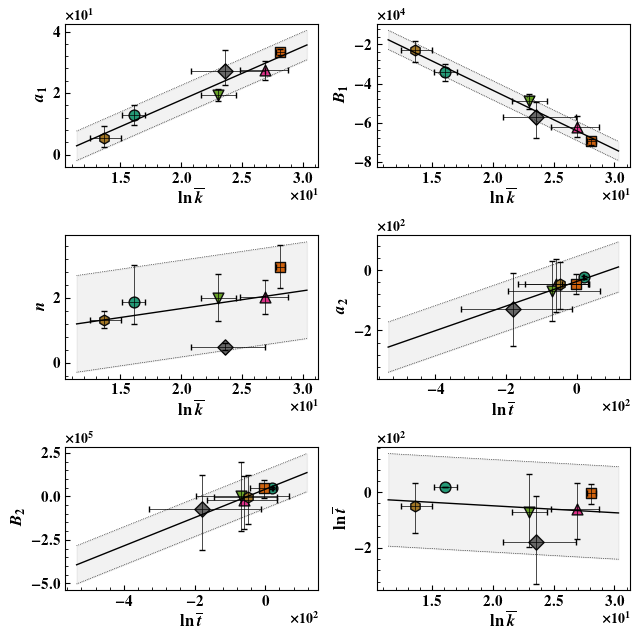

In [4]:
#path stuff
from pathlib import WindowsPath, PosixPath
import sys
PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('../')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference')  
sys.path.append(str(PARENT_DIR))

from common_util import hdi, setup_axis_default,kbar_jmak,kbar_gl,tbar,_FILE_TO_LABEL as file_to_label
from statsmodels.regression.linear_model import OLS
import copy
import math
from typing import List
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib import rc
import warnings
import numpy as np

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

def estimate_latent_model_params(samples: pd.DataFrame,
                                 ycols: List[str],
                                 xcols: List[str] = ['k_bar'],
                                 degree = 1,
                                 **kwargs) -> dict:
    
    models = dict.fromkeys(ycols)
    X = PolynomialFeatures(degree = degree,**kwargs).fit_transform(samples[xcols].to_numpy())
    for ycol in ycols:
        y = samples[ycol].to_numpy()
        ols = OLS(y,X).fit()
        models[ycol] = copy.deepcopy(ols)

    return models

model_name = 'JMAK_{}'
kbar = kbar_jmak if 'JMAK' in model_name else kbar_gl

#somwewhat arbitrary temperature values
T_1 = 800.0 + 273.15
T_2 = 1300.0 + 273.15

#strorage lists
inference_results = {}
total_samples = []

#model parameters
ep = 'n' if 'JMAK' in model_name else 'nu'
model_params = ['a1','B1','a2','B2',ep]

for k,data_name in enumerate(file_to_label.values()):

    #load the maximum likelihood estimates from a file
    ip = pd.read_csv(INFERENCE_PATH.joinpath(f'{model_name.format(data_name)}_params.csv'),index_col = 0).T
    #calculate maximum likelihood of effective rate constant
    for row in ip.index:
        ip.loc[row,'k_bar'] = np.log(kbar(ip.loc[row,'a1'],ip.loc[row,'B1'],ip.loc[row,ep],T_1,T_2))
        ip.loc[row,'t_bar'] = np.log(tbar(ip.loc[row,'a2'],ip.loc[row,'B2'],T_1,T_2))

    #load the samples from a file
    with open(INFERENCE_PATH.joinpath(f'{model_name.format(data_name)}_samples.pkl'),'rb') as f:
        samples = pd.DataFrame.from_dict(pickle.load(f)).iloc[::20]

    #compute the effective rate constant
    samples['k_bar'] = np.empty(samples.shape[0])
    samples['t_bar'] = np.empty(samples.shape[0])
    for row in samples.index:
        with warnings.catch_warnings(action = 'ignore'): 
            samples.loc[row,'k_bar']=  np.log(kbar(samples.loc[row,'a1'],samples.loc[row,'B1'],samples.loc[row,ep],T_1,T_2))
            samples.loc[row,'t_bar'] = np.log(tbar(samples.loc[row,'a2'],samples.loc[row,'B2'],T_1,T_2))
    
    ip.loc[['std'],'k_bar'] = samples['k_bar'].std()  
    ip.loc[['std'],'t_bar'] = samples['t_bar'].std()
    
    samples.drop('sigma',axis = 1,inplace = True)   

    #compute confidence intervals
    for j,col in enumerate(list(samples.columns)):
        for label,ci in zip(['lower','upper'],hdi(samples[col].to_numpy(),0.95).squeeze()):
            ip.loc[label,col] = ci

    total_samples.append(samples.copy())
    inference_results[data_name] = ip.T

#pool all the samples and mle estimates across data sets
total_samples = pd.concat(total_samples,axis = 0) 

#fit linear models of the parameters as a function of the effective rate constant
linear_models = estimate_latent_model_params(total_samples,
                                             ['a1','B1',ep,'t_bar'],
                                             ['k_bar'],degree = 1)

linear_models.update(estimate_latent_model_params(total_samples,
                                                    ['a2','B2'],
                                                    ['t_bar'],degree = 1))

with open(INFERENCE_PATH.joinpath(f'{model_name.format('prior_linear_models')}.pkl'),'wb') as f:  
    pickle.dump(linear_models,f)

#setup axis and formatting
fig,axes = plt.subplots(nrows = 3,ncols = 2,figsize = (6.5,6.5))
colors = plt.get_cmap('Dark2')(np.linspace(0,1,len(file_to_label)))
ylabels = {'a1':r'$a_1$','B1':r'$B_1$','a2': r'$a_2$','B2':r'$B_2$','n':r'$n$','nu': r'$\nu$','k_bar': r'$\ln{\overline{k}}$','t_bar': r'$\ln{\overline{t}}$'}
symbols = np.array(['o','s','^','v','h','D'])
eff_labels = {'k_bar': r'$\ln{\overline{k}}$','t_bar': r'$\ln{\overline{t}}$'}

#pre-compute some plotting ranges
eff_plot = {'k_bar': np.linspace(total_samples['k_bar'].min(),total_samples['k_bar'].max(),100),
            't_bar': np.linspace(total_samples['t_bar'].min(),total_samples['t_bar'].max(),100)}

mean_params = dict.fromkeys(model_params)
for param,eff_col,ax in zip(['a1','B1',ep,'a2','B2','t_bar'],
                                     ['k_bar']*3 + ['t_bar']*2 + ['k_bar'],axes.ravel()):
    setup_axis_default(ax)

    #easier to visualize if we use different colors/symbols for different studies
    for j,data_name in enumerate(file_to_label.values()):
        ml_params = inference_results[data_name]
        yerr  = np.abs(ml_params.loc[param,['mean']].to_numpy() - ml_params.loc[param,['lower','upper']].to_numpy())
        xerr = np.abs(ml_params.loc[eff_col,['mean']].to_numpy() - ml_params.loc[eff_col,['lower','upper']].to_numpy())
        ax.scatter(ml_params.loc[eff_col,'mean'],ml_params.loc[param,'mean'],color = colors[j],
                   marker = symbols[j],s = 60,edgecolor = 'k')
        ax.errorbar(ml_params.loc[eff_col,'mean'],ml_params.loc[param,'mean'],
                    yerr= yerr[:,np.newaxis],xerr = xerr[:,np.newaxis],
                    elinewidth = 0.5,capsize = 2,ls = 'none',color = 'k')
    
    #make predictions with confidence intervals using the linear model for visualization
    Xplot = np.array([np.ones(eff_plot[eff_col].shape[0]),eff_plot[eff_col]]).T
    pred = linear_models[param].get_prediction(Xplot)
    mean_pred = pred.predicted_mean
    mean_params[param] = mean_pred.mean()
    conf_int = pred.conf_int(0.95)

    #plot the linear model predictions and confidence intervals
    ax.plot(eff_plot[eff_col],mean_pred,lw = 1.0,color = 'k') 
    ax.fill_between(eff_plot[eff_col],conf_int[:,0],conf_int[:,1],color = 'grey',alpha = 0.1)
    for j in range(2):
        ax.plot(eff_plot[eff_col],conf_int[:,j],lw = 0.5,color = 'k',ls = ':')

    ax.set_ylabel(ylabels[param],fontsize = 12)
    ax.set_xlabel(eff_labels[eff_col],fontsize = 12)   
    ax.ticklabel_format(axis = 'both',style = 'sci',scilimits = (0,0))


fig.tight_layout() 